## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cpu'

## 1. Get data

The dataset is a subset of the Food101 dataset.

Food101 starts 100 different classes and 1000 images per class.

OUr dataset starts with 3 classes of food and only 10% of the images.

When starting a ML project its imporant to speed up the process of experimentation.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# IF the iamge folder does not exist, make on
if image_path.is_dir():
  print(f'{image_path} exists')
else:
  print(f'{image_path} does not exists, creating one ...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, stake and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # 'wb' --> write binary
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloadein data ...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data ... ")
  zip_ref.extractall(image_path) # extract info from the zip data to the image path

data/pizza_steak_sushi exists
Downloadein data ...
Unzipping data ... 


## 2. Becoming one with the data( data prep and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  '''Walks thourgh dir_path returning its contents.'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} image in {dirpath}.')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 image in data/pizza_steak_sushi.
There are 3 directories and 0 image in data/pizza_steak_sushi/train.
There are 0 directories and 78 image in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 75 image in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 image in data/pizza_steak_sushi/train/sushi.
There are 3 directories and 0 image in data/pizza_steak_sushi/test.
There are 0 directories and 25 image in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 19 image in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 image in data/pizza_steak_sushi/test/sushi.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Pythons random.choice()
3. Get the image class names using pathlib.Path.parent.stem
4. Since we are working with iamges, lets open it with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/2121603.jpg
Image class: pizza
Image height: 512
Image width: 384


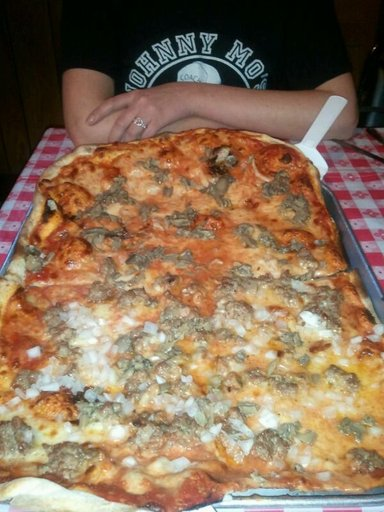

In [7]:
import random
from PIL import Image

# Set seed
# random.seed(42)


# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get iamge class from path name (the image class is the name of the dir where the img is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

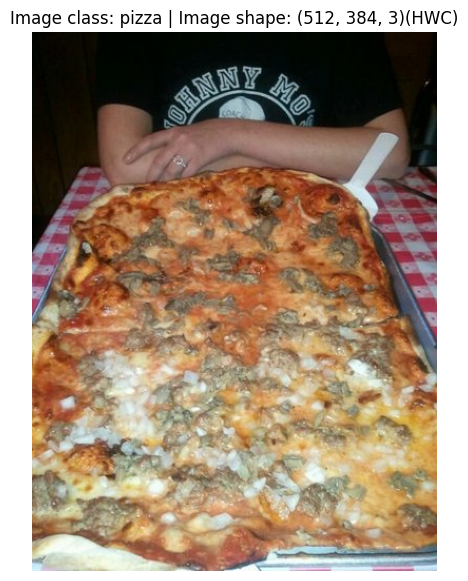

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}(HWC)")
plt.axis(False)

## 3. Transforming data

Before we can use our image data wiht PyTorch:
1. Turn your target data into tensors( in our case, numerical represnetation of images).
2. Turn it inot `torch.utils.data.Dataset` and subsequently a torch.utils.data.DataLoader(batched version of our data set)

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

https://pytorch.org/vision/stable/transforms.html

https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [10]:
# Write a transform for image(PIL --> Tensor)
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # File the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

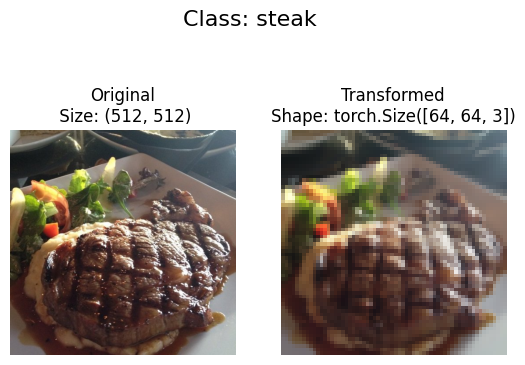

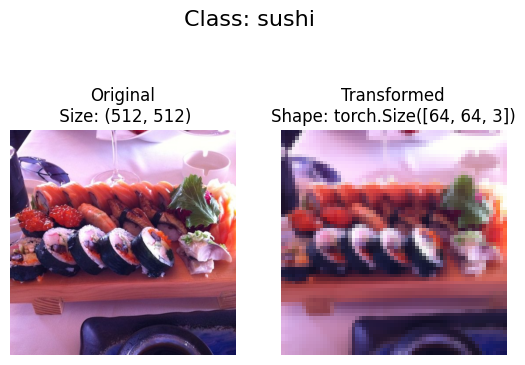

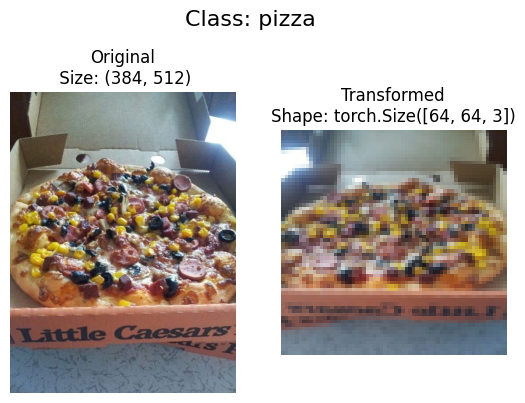

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transfomred version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2) # returns a figure object (fig) and an array of Axes objects (ax)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib(C,H,W) -> (H,W,C)
                                       # matplotlib prefers color channels last
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16) # big title on top

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed = 4)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using torchvision.datasets.ImageFolder

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)


train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# GEt clas names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# GEt calss names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

In [18]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Imgae label: {label}, {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [c,h,w]
Image permute: torch.Size([64, 64, 3]) -> [h,w,c]


Text(0.5, 1.0, 'pizza')

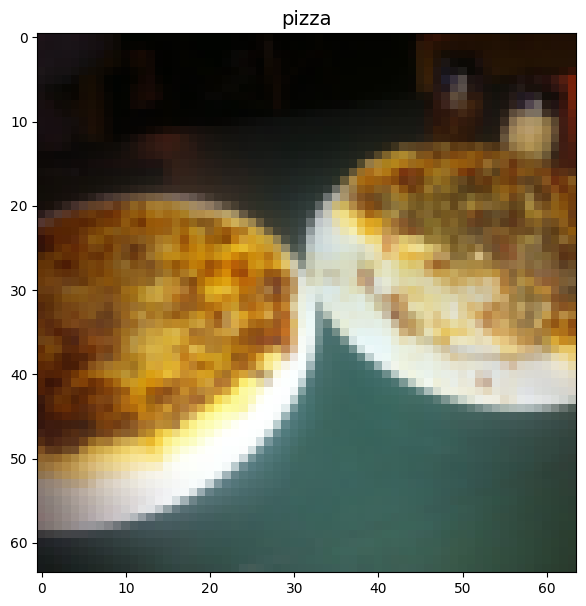

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original shape: {img.shape} -> [c,h,w]")
print(f"Image permute: {img_permute.shape} -> [h,w,c]") # plt like it that way

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)

### 4.1  Turn loaded images into DataLoader's

A `DataLoader` is going to hel us turn our Dataset into iterables and we can customise the `batch_size` os our model can see `batch_size` images at a time.

In [20]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),#  how many cpu cores it uses
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [21]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78df92132a10>,
 <torch.utils.data.dataloader.DataLoader at 0x78df92131780>)

In [22]:
len(train_dataloader), len(test_dataloader)

(29, 10)

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))

# Batch size will now be 8
print(f"Image shape: {img.shape} -> [batch_size, c, h, w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, c, h, w]
Label shape: torch.Size([8])


## 5. Option 2: Loading a Image Data with a Custom Dataset

1. Want ot be able to load images from file
2. Want to be able to get class names fomr Dataset
3. Want to be able to get classes as dicionarty from the Dataset

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-build Dataset function

Cons:
* Even though you could create a Dataset out of almost anything, it does not mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performence issues

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directiory (ideally the dir is in a standard image classification format)
2. Raise an error if the class names are not founcd(if this happens, there might be something wrong with the dir structure)
3. Turn the class names into a dict and a lsit and return them

In [27]:
# Setup path for target dir
target_directory = train_dir
print(f"Target dir: {target_directory}")

Target dir: data/pizza_steak_sushi/train


In [28]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [29]:
# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  ''' Find the class folder names in a target dir. '''
  # 1. Get the class names by scanning the target dircetory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Rasie an error if class names could not be fonud
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}... please check file strucutre.")

  # 3. Create a dictionary of index labels (computer prefer numbers rather than str as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Createa a custom Datast to replicate ImageFolder

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target dir (the dir wed like to get data from) as well as a transform if wed like to transform our data.
3. Create several attributes:
  * paths- paths of our images
  * transform - the transofmr wed like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to int labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the len of our data set
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [32]:
# 0. Write a custom dataet class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
      #3. Create class attributes
      # Get all of the iamge paths
      self.path = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
      # Setup transforms
      self.transform = transform
      # Create classes and class_to_idx attributs
      self.classes, self.class_to_idx = find_classes(targ_dir)


    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
      " Opens an image via a path and returns it."
      image_path = self.path[index]
      return Image.open(image_path)

    # 5. Overwrite __len()__
    def __len__(self) -> int:
      "returns the total numer of samples."
      return len(self.path)

    # 6. Overwrite __getitem__() method to return a particualr sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
      "Returns one sample of data, data and label (X, y)."
      img = self.load_image(index)
      class_name = self.path[index].parent.name # expects path in format: data_folder/class_name/image.jpg
      class_idx = self.class_to_idx[class_name]

      # Transform if necessary
      if self.transform:
        return self.transform(img), class_idx # return data, label (X, y)
      else:
        return img, class_idx # return untransformed image and label

In [33]:
# Creata a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
])

In [34]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78df921765c0>,
 <__main__.ImageFolderCustom at 0x78df921772e0>)

In [36]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [37]:
len(train_data), len(test_data)

(225, 75)

In [38]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [39]:
train_data_custom.classes, train_data.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [40]:
train_data_custom.class_to_idx, train_data.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to display random iamges

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of image to see at 10.
3. Set the random seef for reproducibility
4. Get a list of random sample indexes fro mteh target dataset.
5. Setup a matplotlib plot
6. Loop htroug the random sample images and plot them with matplot lib
7. Make usre the dimension of our image s line up with matplotlib

In [41]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n should not be larger than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexs
  random_samples_idx = random.sample(range(len(dataset)), k = n )

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexs and plot them with matplotlob
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)
    plt.axis(False)

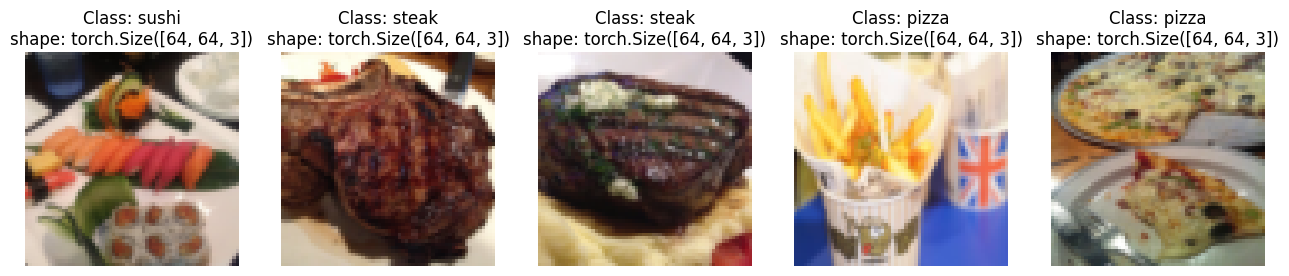

In [42]:
# Display ranodm images from the ImageFolder created Dataset
display_random_images(dataset = train_data,
                      n = 5,
                      classes = class_names,
                      seed=None)

For display, purposes, n should not be larger than 10


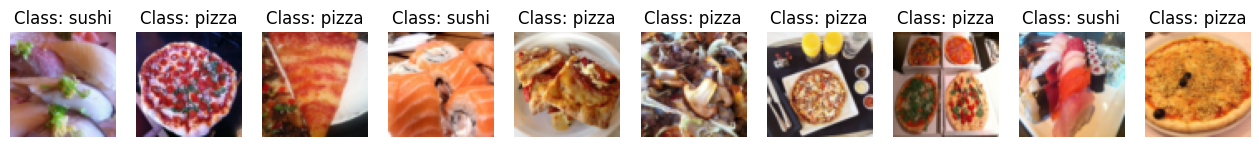

In [43]:
# Display random images from the ImageFolder Custom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [44]:
from torch.utils.data import DataLoader
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)


In [45]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78df9219ee60>,
 <torch.utils.data.dataloader.DataLoader at 0x78df922339a0>)

In [46]:
# Single image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8]))

## 6. Other forms of transforms (data augmentation)

Data Augmentation is the process of artificially adding diveristy to your training data.

In case of the image data, this may mean applying various image transformations to the traing images.

This practice hopefully results in a model that more generalizable to unseen data.

Let;s take a look at one particualr type of data augmentation used to train PyTorch vision models to state of the art levels...

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [47]:
# Let's look at trivial Augment --> https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose(
    [
        transforms.Resize(size=(244,244)),
        transforms.TrivialAugmentWide(num_magnitude_bins=5), # intensity of change
        transforms.ToTensor()
    ]

)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ]
)

In [48]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/2493954.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2426686.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2576168.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1660415.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1524655.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/928670.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2702825.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3338774.jpg')]

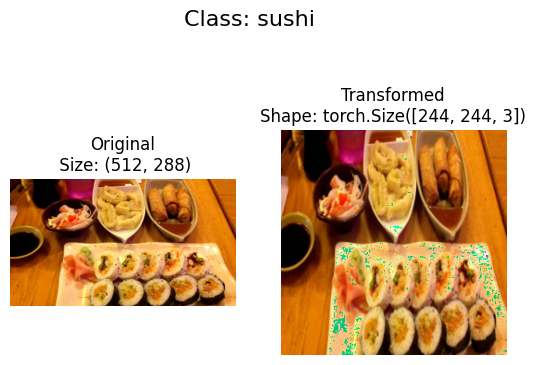

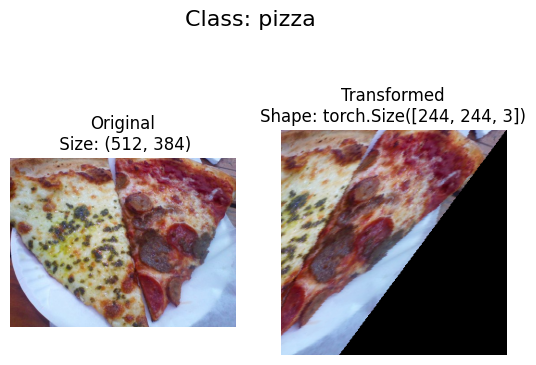

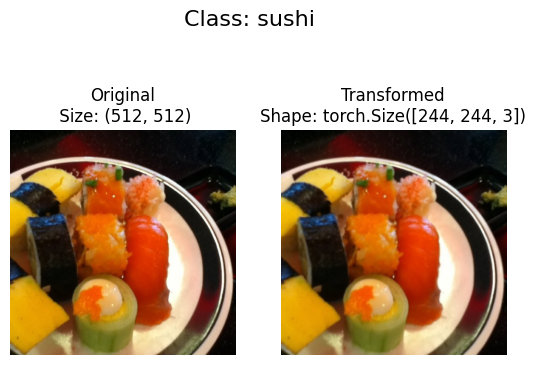

In [49]:
# Plot random transformed iamges
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [50]:
# Create simple transform
simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64,64)),
        transforms.ToTensor()
    ]
)



In [51]:
# 1. Load and transform data

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model

In [52]:
class TinyVGG(nn.Module):
  ''' Model architecture TinyVGG '''
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x # if you do it in one line you fenefit from operator funsion https://horace.io/brrr_intro.html

In [53]:
torch.manual_seed(42)
model0 = TinyVGG(input_shape = 3, # input colors
                 hidden_units = 10,
                 output_shape=len(class_names)).to(device)
model0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image(to test the model)

In [54]:
# Geet a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [55]:
# Try a forward pass
model0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfoo` to get an idea of the shapes going through our model



In [56]:
# Install torchinfo, import if it's avaiable
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo


from torchinfo import summary
summary(model0, input_size = [32, 3, 64, 64]) # example of data flow through the model

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loops

* `train_step()` - takes in a model and datalaoder and trains the model on the dataloader
* `test_step()` - taeks in a model and dataloader and evaluates the model on the dataloader

In [57]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # PU the model in train mode
  model.train()

  #Setup train loss and train accvalues
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer setp
    optimizer.step()

    # Calc accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_Acc = train_acc /len(dataloader)
  return train_loss, train_acc

In [58]:
# Creat a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # Adjust metric to get average loss and acc per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [59]:
from tqdm.auto import tqdm

# 1. create a function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2. Create empty result dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testng and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print out what's happening
    print(f" Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}| Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update resutls dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Retursn the filled results at the end of the epochs
  return results


### 7.7 Train and evalue model 0

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

# Recreate an instence of TinnyVVG
model0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.001)


from timeit import default_timer as timer
start_time = timer()

# Train model0
model0_results = train(model=model0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch: 0 | Train loss: 1.1063 | Train acc: 2.4375| Test loss: 1.0983 | Test acc: 0.3011
 Epoch: 1 | Train loss: 1.0998 | Train acc: 2.6250| Test loss: 1.0697 | Test acc: 0.5417
 Epoch: 2 | Train loss: 1.0869 | Train acc: 3.9062| Test loss: 1.0808 | Test acc: 0.4924
 Epoch: 3 | Train loss: 1.0842 | Train acc: 3.1875| Test loss: 1.0608 | Test acc: 0.5833
 Epoch: 4 | Train loss: 1.0662 | Train acc: 3.3125| Test loss: 1.0654 | Test acc: 0.5644
Total training time: 16.121 seconds


### 7.8 Plot the loss curve of Model0

A **loss curve** is a way of tracking the progress of the model over time.

In [61]:
# Get the model0_results keys
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [62]:
def plot_loss_curve(results: Dict[str, List[float]]):
  ''' Plots training curves of a results dict '''
  # Get the loss values of results dict
  loss = results["train_loss"]
  test_loss =results["test_loss"]

  # Get the accuray values of the results dict
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the acc
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

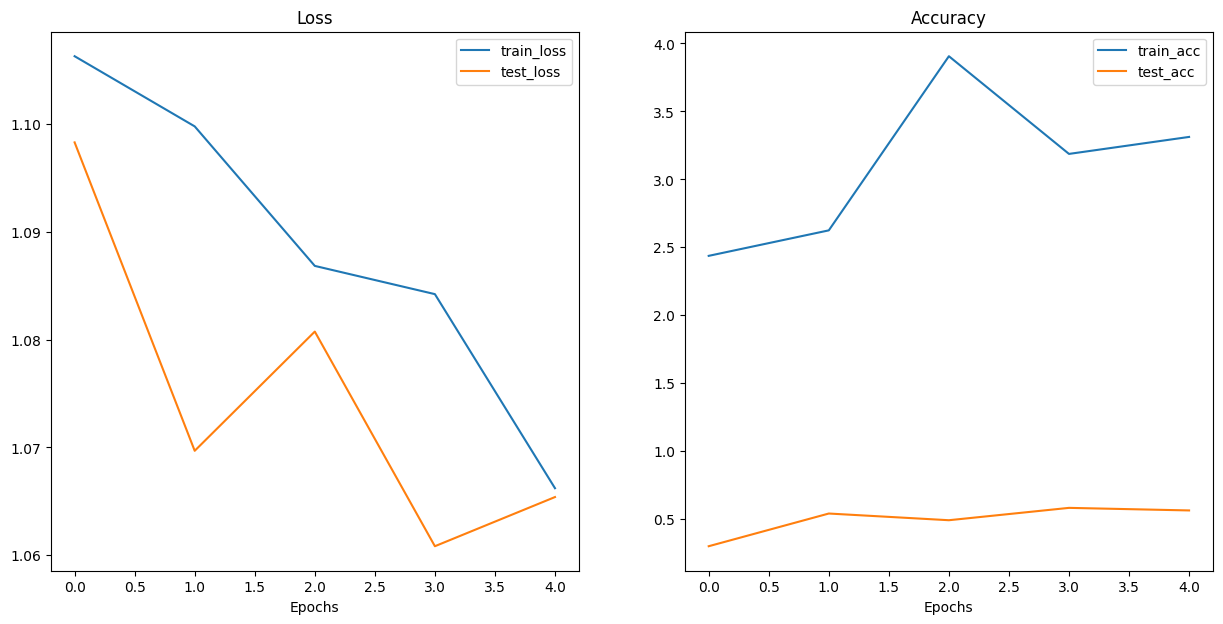

In [63]:
plot_loss_curve(model0_results)

## 8. What should an ideal loss curve look like?

A Loss curve is one of the most helpful ways to troubleshoot a model.

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

## 9. TinyVGG with data augmentation

Now let's try another modeling experiment this time using the same model as before with some data augmentation.

### 9.1 Create trsnfrom with data augmentation

In [64]:
# Create training trsnfomr with TrivialAugment
train_transform_traivial = transforms.Compose(
    [
        transforms.Resize(size=(64,66)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)

test_transform_simple = transforms.Compose(
    [
        transforms.Resize(size=(64,64)),
        transforms.ToTensor()
    ]
)

### 9.2 Create train and test `Dataset` and `DataLoader` with data augmentation

In [65]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_traivial)

test_data_simplt = datasets.ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [66]:
# Turn out Datasets into DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers=NUM_WORKERS)



### 9.3 Construct and train mode1

Same model architecture except this time we changed the training data

In [67]:
# Create model1
torch.manual_seed(42)
model1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [74]:
 torch.manual_seed(42)
 torch.cuda.manual_seed(42)

 EPOCHS = 5

 loss_fn = nn.CrossEntropyLoss()
 optimizer = torch.optim.Adam(params=model1.parameters(),
                              lr=0.001)

 start_time = timer()

 model1_results = train(model=model1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

 end_tiem = timer()

 print(f"Total training time for model1: {end_tiem-start_time:.3f}s")

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch: 0 | Train loss: 1.0159 | Train acc: 4.0000| Test loss: 1.0186 | Test acc: 0.3523
 Epoch: 1 | Train loss: 1.0482 | Train acc: 3.4375| Test loss: 1.0598 | Test acc: 0.3428
 Epoch: 2 | Train loss: 0.8958 | Train acc: 4.4375| Test loss: 1.0774 | Test acc: 0.3428
 Epoch: 3 | Train loss: 0.9516 | Train acc: 4.6875| Test loss: 1.0865 | Test acc: 0.3333
 Epoch: 4 | Train loss: 0.9279 | Train acc: 4.5312| Test loss: 1.0917 | Test acc: 0.3523
Total training time for model1: 11.901s


### 9.4 Plot the loss curves of model1

A loss curve helps you evalute your models performence overtime.

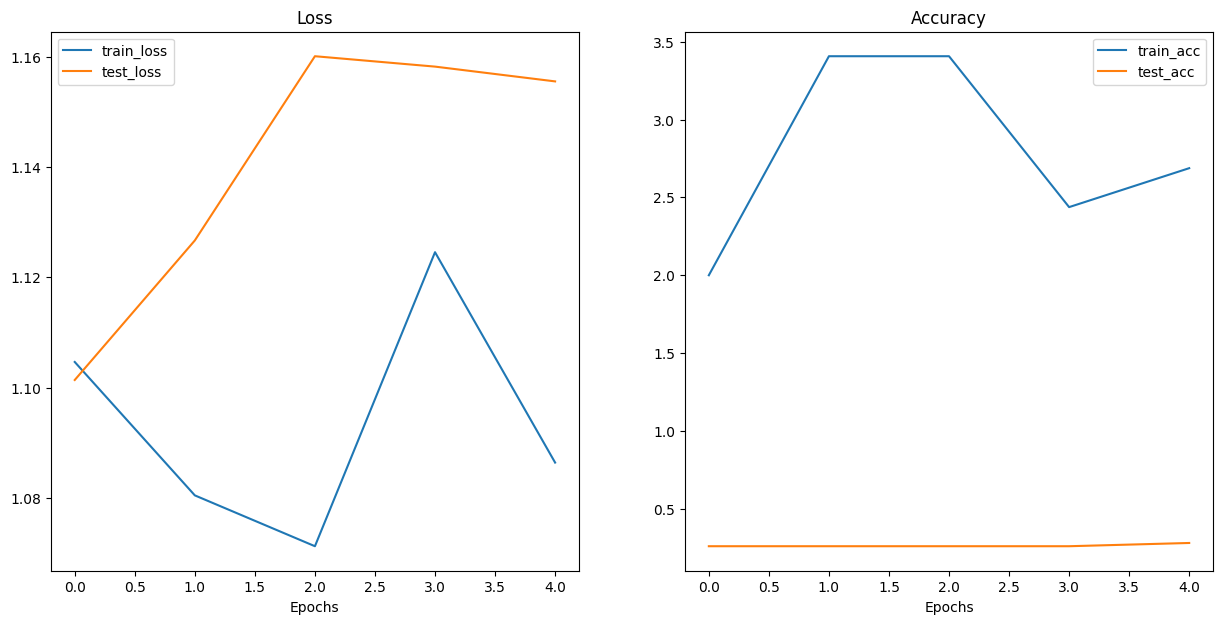

In [71]:
 plot_loss_curve(model1_results)

## 10. Compare model results

After evaluation our modellign experiemnt on thier own, it''s importnat to compare them to each other.

1. Hard coding
2. PyTorch + Tensorboard
3. Weights and Biases
4. mlflow

In [75]:
import pandas as pd
model_0_df = pd.DataFrame(model0_results)
model_1_df = pd.DataFrame(model1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,2.43750,1.098321,0.301136
1,1.099806,2.62500,1.069690,0.541667
2,1.086854,3.90625,1.080757,0.492424
3,1.084233,3.18750,1.060832,0.583333
4,1.066216,3.31250,1.065396,0.564394


In [76]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.015907,4.00000,1.018607,0.352273
1,1.048207,3.43750,1.059833,0.342803
2,0.895779,4.43750,1.077411,0.342803
3,0.951625,4.68750,1.086482,0.333333
4,0.927861,4.53125,1.091715,0.352273


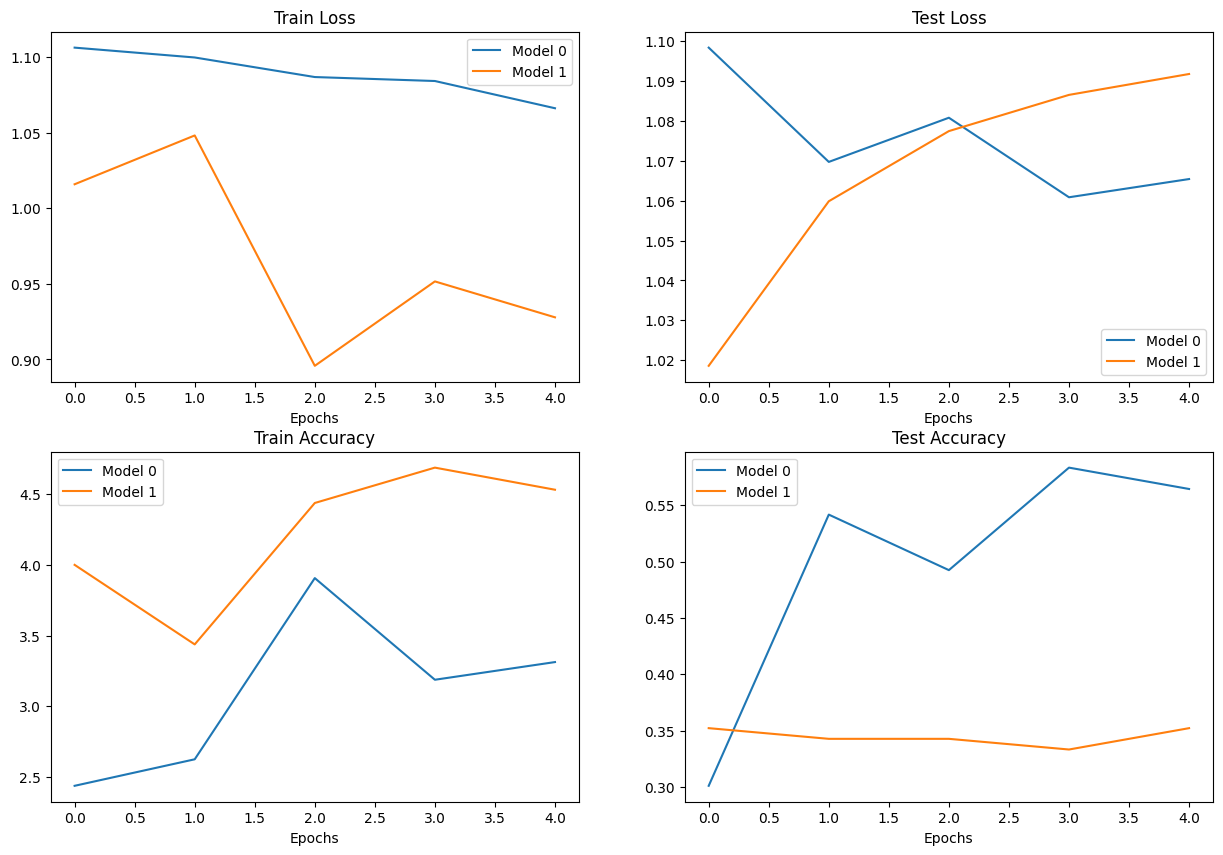

In [77]:
#  Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Altoiguh we've trained a model on custom data... how do you make a prediction on a sample/image that's not in the data

In [78]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it does not already exists
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # raw link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path} ...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom iamge is in the same format as the data our model was trained on.

* In tensor form with dtype torch.float32
* Of shape 64x64x3
* On the right device

In [80]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

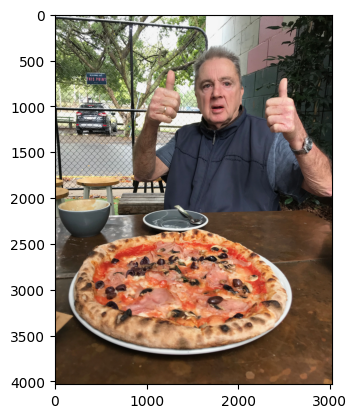

In [83]:
plt.imshow(custom_image_uint8.permute(1, 2,0))

In [85]:
custom_image_uint8.shape, custom_image_uint8.dtype, custom_image_uint8.device

(torch.Size([3, 4032, 3024]), torch.uint8, device(type='cpu'))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [91]:
# Load custom iamge and convert to float 32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 225 # devive a big number by 255 to mkae them between 0 and 1
custom_image

tensor([[[0.6844, 0.7689, 0.8044,  ..., 0.0933, 0.0800, 0.0622],
         [0.6489, 0.7333, 0.8044,  ..., 0.0933, 0.0800, 0.0667],
         [0.5511, 0.6489, 0.7644,  ..., 0.0800, 0.0756, 0.0667],
         ...,
         [0.3200, 0.2622, 0.2000,  ..., 0.6756, 0.6667, 0.6578],
         [0.2844, 0.2444, 0.1822,  ..., 0.6667, 0.6533, 0.6400],
         [0.2844, 0.2667, 0.2044,  ..., 0.6622, 0.6489, 0.6356]],

        [[0.7600, 0.8444, 0.8578,  ..., 0.0978, 0.0844, 0.0667],
         [0.7244, 0.8089, 0.8578,  ..., 0.0978, 0.0844, 0.0711],
         [0.6267, 0.7244, 0.8178,  ..., 0.0844, 0.0800, 0.0711],
         ...,
         [0.2444, 0.1867, 0.1244,  ..., 0.4756, 0.4622, 0.4578],
         [0.2089, 0.1689, 0.1067,  ..., 0.4800, 0.4622, 0.4533],
         [0.2089, 0.1911, 0.1289,  ..., 0.4756, 0.4622, 0.4489]],

        [[0.5289, 0.6133, 0.6533,  ..., 0.0756, 0.0622, 0.0444],
         [0.4933, 0.5778, 0.6444,  ..., 0.0756, 0.0622, 0.0489],
         [0.3867, 0.4933, 0.6044,  ..., 0.0622, 0.0578, 0.

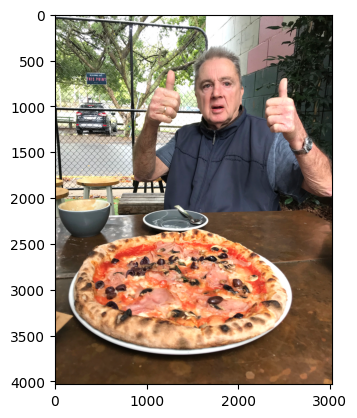

In [94]:
plt.imshow(custom_image.permute(1,2,0))

In [99]:
# Create trsnform pipeline to resize image
custom_image_transform = transforms.Compose(
    [
        transforms.Resize(size=(64,64))
    ]
)

# Transform target iamge
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


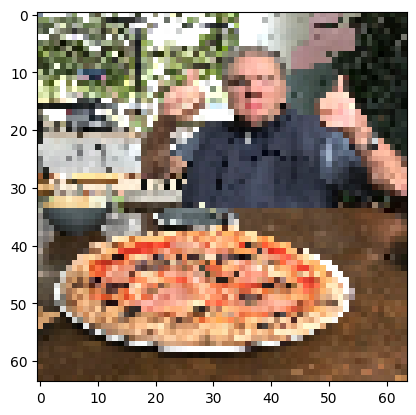

In [101]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [103]:
# This will erro: no batch size
model1.eval()
with torch.inference_mode():
  custom_image_pred = model1(custom_image_transformed.to(device))

RuntimeError: ignored

In [108]:
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [110]:
model1.eval()
with torch.inference_mode():
  custom_image_pred = model1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[ 0.0177, -0.5181, -0.6795]])

In [112]:
class_names

['pizza', 'steak', 'sushi']

In [115]:
print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1).cpu()
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.0177, -0.5181, -0.6795]])
Prediction probabilities: tensor([[0.4800, 0.2809, 0.2390]])
Prediction label: tensor([0])


In [117]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom iamge prediction together: building a function

Ideal outcome:

A fucntion where we pass an image path to and have our model predict on that image nad plot the image + prediction.

In [122]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
  ''' Make a pred on a target image with a trained model and plots the iamge and prediction. '''
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Devide the image pixel value by 255 to get them between [0,1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target devide
  model.to(device)

  # Turn on eval mode and make a pred
  model.eval()
  with torch.inference_mode():
    # Add an extra dim to the image (batch dim)
    target_image = target_image.unsqueeze(0)

    # Make a pred on the image with an extra dim
    target_image_pred = model(target_image.to(device)) # make sure target iamge in on the device

  # Convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert pred prob --> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the pred and pred prob
  plt.imshow(target_image.squeeze().permute(1, 2, 0))# remove batch dim and rearrange shape to be HWC
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


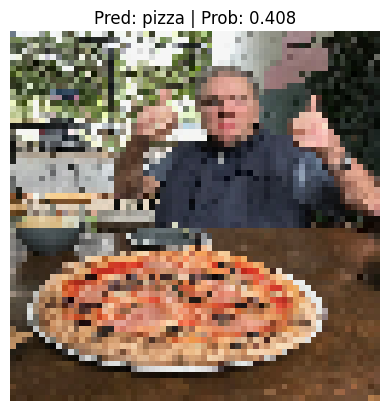

In [123]:
pred_and_plot_image(model=model1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)